In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



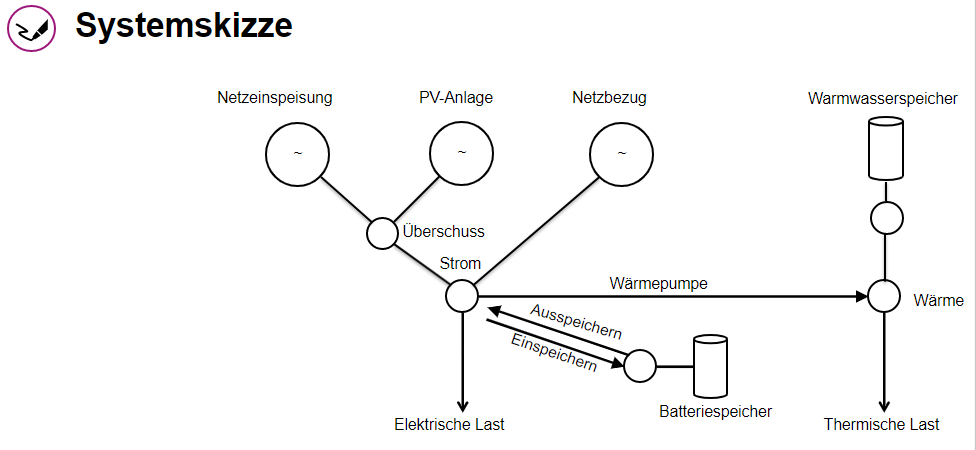

In [2]:
# Systemskizze für das Referenzmodell -> Bestimmen welcher Autarkiegrad möglich ist und schauen zu welchen Konditionen überhaupt
# Auch hier können bereits Parameter verändert werden
# Sensivitätsanalyse/ Strompreis abhängigkeit/ größe des Speichers im Verhältnis zum Investiotionslimit etc.pp

In [3]:
#csv-Datei importieren
csv_datei = "Modellierung_SoSe23.csv"
df_data = pd.read_csv(csv_datei, sep=';', decimal = ',')
df_data

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last,Außentemperatur
0,01.01. 00:00,0.016247,0.0,0.0,0.22,10.70
1,01.01. 01:00,0.016162,0.0,0.0,0.13,10.77
2,01.01. 02:00,0.016005,0.0,0.0,0.07,10.55
3,01.01. 03:00,0.166450,0.0,0.0,0.03,10.44
4,01.01. 04:00,0.016200,0.0,0.0,0.07,10.34
...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,1.69,0.83
8756,31.12. 20:00,0.261240,0.0,0.0,1.73,0.51
8757,31.12. 21:00,0.289830,0.0,0.0,1.33,0.20
8758,31.12. 22:00,0.340810,0.0,0.0,0.81,-0.12


In [4]:
# Bezeichnung der einzelnen Spalten

elektrische_last = df_data['Verbrauch ']
pv_ertrag        = df_data['PV-Ertrag']
thermische_last  = df_data['Thermische Last ']
Temeperatur      = df_data['Außentemperatur']

print(df_data.sum())

Zeit                01.01. 00:0001.01. 01:0001.01. 02:0001.01. 03:...
Verbrauch                                                 3304.001502
PV-Ertrag                                                 11581.69408
Netzeinspeisung                                           10261.18077
Thermische Last                                              10000.43
Außentemperatur                                              96022.25
dtype: object


In [5]:
# Berechnung des COPs der Wärmepumpe/ Daten vom Prof.

tabelle_x = [-15, -7, 2, 7, 10, 12, 20, 25, 30, 35]
cop_y = [1.7, 2.3, 2.6, 3, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]

df_data['COP_Tabelle']=np.interp(df_data['Außentemperatur'], 
                                             tabelle_x, cop_y)
wp_el_p_nom = 12.5 #kW
elektr_leistung_y = [14.58, 15.54, 16.7, 18.56, 18.79, 18.87, 19.05, 19.13, 19.36, 19.46]

df_data['WP_p_max_pu'] = np.interp(df_data['Außentemperatur'], 
                                     tabelle_x, elektr_leistung_y)/wp_el_p_nom
df_data

,Zeit,Verbrauch,PV-Ertrag,Netzeinspeisung,Thermische Last,Außentemperatur,COP_Tabelle,WP_p_max_pu
0,01.01. 00:00,0.016247,0.0,0.0,0.22,10.70,3.235000,1.505440
1,01.01. 01:00,0.016162,0.0,0.0,0.13,10.77,3.238500,1.505664
2,01.01. 02:00,0.016005,0.0,0.0,0.07,10.55,3.227500,1.504960
3,01.01. 03:00,0.166450,0.0,0.0,0.03,10.44,3.222000,1.504608
4,01.01. 04:00,0.016200,0.0,0.0,0.07,10.34,3.217000,1.504288
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,0.0,0.0,1.69,0.83,2.561000,1.323936
8756,31.12. 20:00,0.261240,0.0,0.0,1.73,0.51,2.550333,1.320636
8757,31.12. 21:00,0.289830,0.0,0.0,1.33,0.20,2.540000,1.317440
8758,31.12. 22:00,0.340810,0.0,0.0,0.81,-0.12,2.529333,1.314140


In [6]:
WP_p_max_pu      = df_data['WP_p_max_pu']

#Basissystem
pv_p_nom = 10 # in kWp 
#pv_p_nom = 20 # in kWp                 # funktioniert nicht auf 20 kWp, da festes Profil hinterlegt - Skalierung versuchen?
pv_p_pu = pv_ertrag/pv_p_nom

#Annahmen für das Ref-Netzwerke

#Marginale Kosten
strompreis_bezug = 0.40                            
strompreis_einspeisung = -0.08
gas_preis = 0.158

#Kapitalkosten pro Jahr pro kW
kapital_kosten_batteriespeicher = 892/12.5              #892€/kWh auf 12.5 Jahre
kapital_kosten_warmwasserspeicher = 53.32/20            #[€/kWh/a] Preis(1965€)/36,85kWh (800l)/ Lebensdauer sind 20 Jahre
kapital_kosten_wp = (25000 / 7.5) / 25                 # [€/kW] - Preis(25.000€) pro Leistung [kW]
#kapital_kosten_wp = (8500 / 3) / 20                     # Versuch 2: kleinere WP mit anderem Preis
kapital_kosten_pv = (1300*10)/20                        #10kWp Anlage ink. WR für 20000€ auf 20 Jahre

#Wirkungsgrade der Komponenten
wirkungsgrad_batteriespeicher_laden = 0.88        
wirkungsgrad_batteriespeicher_entladen = 0.88           #Wirkungsgrad von wurzel(77%)
selbstentlade_verluste_bs = 0.07
selbstentlade_verluste_ps = 0.08

In [7]:
df_data['WP_p_max_pu'].max()

1.554992

In [8]:
summe = df_data['COP_Tabelle'].sum()

anzahl = len(df_data['COP_Tabelle'])

durchschnitt = summe/anzahl 

print(durchschnitt)

3.1461300646879753


In [9]:
n_ref = pypsa.Network()
n_ref.set_snapshots(df_data.index)


#Hinzufügung Bus
n_ref.add('Bus', name = 'strom')
n_ref.add('Bus', name = 'batterie')
n_ref.add('Bus', name = 'ueberschuss')
n_ref.add('Bus', name = 'waerme')

#Hinzufügung der Lasten
n_ref.add('Load', name = 'elektrischeLast',bus = 'strom' , p_set  = elektrische_last)
n_ref.add('Load', name = 'thermischelast', bus = 'waerme' , p_set = thermische_last)

#Hinzufügung der Generatoren
n_ref.add('Generator', name = 'PV',              bus = 'ueberschuss', p_nom = pv_p_nom, 
            p_max_pu = pv_p_pu, capital_cost = kapital_kosten_pv)
n_ref.add('Generator', name = 'Netzeinspeisung', bus = 'ueberschuss', 
            marginal_cost = strompreis_einspeisung, sign = -1, p_nom_extendable = True)
n_ref.add('Generator', name = 'Netzbezug',       bus = 'strom', marginal_cost = strompreis_bezug, p_nom = elektrische_last.max())

#Hinzufügung der Speicher
n_ref.add('Store', name = 'battriespeicher',  bus = 'batterie', e_nom_extendable = True, capital_cost = kapital_kosten_batteriespeicher, standing_loss = selbstentlade_verluste_bs, e_cyclic = True)
n_ref.add('Store', name= 'warmwasserspeicher', bus= 'waerme', e_nom_extendable = True ,
            e_nom_max = 36.85, capital_cost= kapital_kosten_warmwasserspeicher, standing_loss= selbstentlade_verluste_ps)

#Hinzufügung der Links
n_ref.add('Link', name = 'Einspeichern',   bus0 = 'strom',       bus1    = 'batterie', p_nom_extendable = True,  efficiency   = wirkungsgrad_batteriespeicher_laden)
n_ref.add('Link', name = 'Ausspeichern',   bus0 = 'batterie',    bus1    = 'strom',    p_nom_extendable = True, efficiency = wirkungsgrad_batteriespeicher_entladen)
n_ref.add('Link', name = 'eigenverbrauch', bus0 = 'ueberschuss', bus1    = 'strom',    p_nom_extendable = True)
n_ref.add('Link', name = 'waermepumpe',    bus0 = 'strom',       bus1    = 'waerme',   p_nom_extendable = True, efficiency = df_data['COP_Tabelle'], capital_cost= kapital_kosten_wp)

In [10]:
n_ref.optimize(solver_name = 'gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.21it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-k6ft8tv9.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x349538ee
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.14s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 1.17e+03
Solver model: available
Solver message: 2



('ok', 'optimal')

<Axes: xlabel='snapshot'>

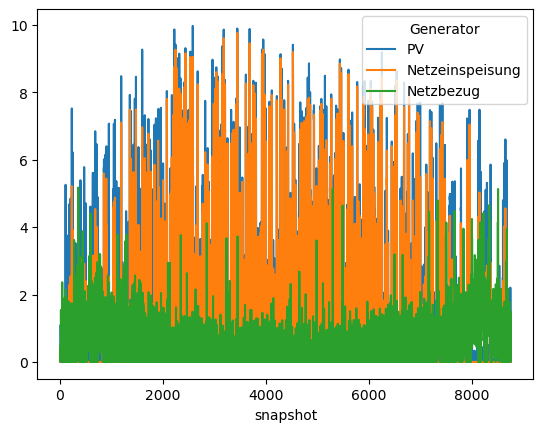

In [11]:
n_ref.generators_t.p.plot()

In [12]:
n_ref.generators_t.p['Netzeinspeisung'].sum()

7841.146603966185

<Axes: xlabel='snapshot'>

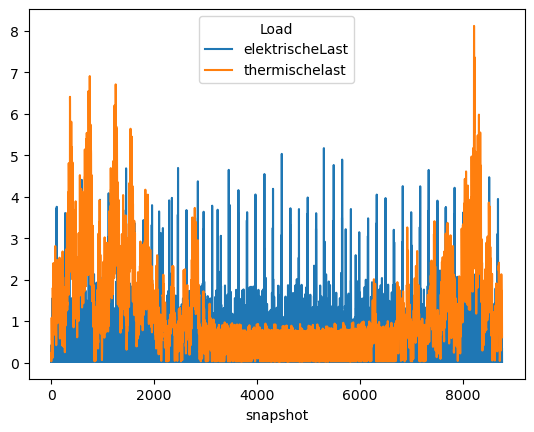

In [13]:
n_ref.loads_t.p.plot()

In [14]:
n_ref.generators_t.p.sum()

Generator
PV                 11581.694080
Netzeinspeisung     7841.146604
Netzbezug           3563.313715
dtype: float64

In [15]:
n_ref.stores.e_nom_opt

Store
battriespeicher        0.078446
warmwasserspeicher    21.353622
Name: e_nom_opt, dtype: float64

In [16]:
n_ref.loads_t.p.sum()

Load
elektrischeLast     3304.001502
thermischelast     10000.430000
dtype: float64

array([<Axes: xlabel='snapshot'>, <Axes: xlabel='snapshot'>,
       <Axes: xlabel='snapshot'>], dtype=object)

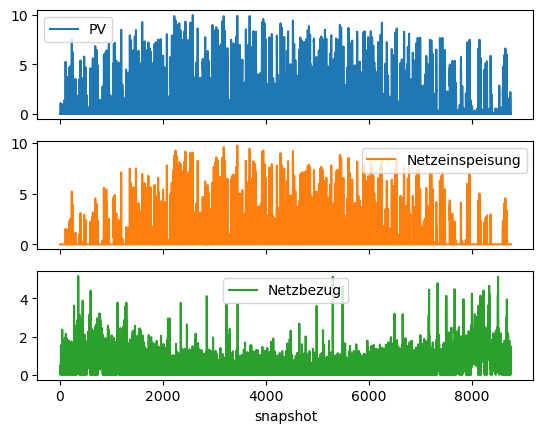

In [17]:
#Darstellung der Generatoren-Jahreslinie
n_ref.generators_t.p.plot(subplots=True)

array([<Axes: xlabel='snapshot'>, <Axes: xlabel='snapshot'>], dtype=object)

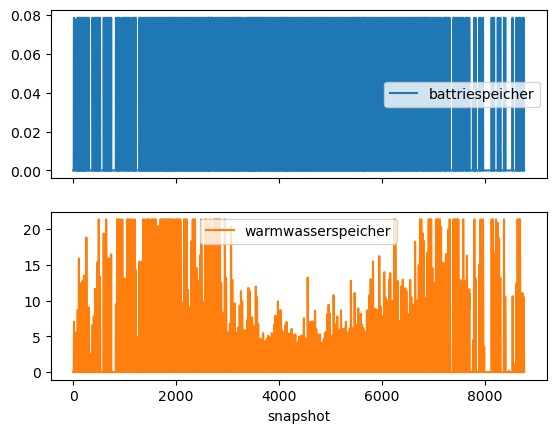

In [18]:
#Darstellung der Generatoren-Jahreslinie
n_ref.stores_t.e.plot(subplots= True)

In [19]:
n_ref.links.p_nom_opt.waermepumpe

2.2917356452180258

In [20]:
#Definieren der zweiten Auswertungsfunktion (Wärmepumpe) ohne Sensitivitäsanaly

def auswertungsfunktion(network, sensitivity_variable = 0): 
    
    #Funktion der laufenden kosten
    
    #Funktion der laufende Kosten
    laufende_kosten_generators = (network.generators_t.p.Netzbezug * network.generators.marginal_cost.Netzbezug  +
                                       network.generators_t.p.Netzeinspeisung * network.generators.marginal_cost.Netzeinspeisung).sum()
    #Funktion für Investitionskosten
#kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
    kapital_kosten_generators = (network.generators.p_nom_opt.PV * network.generators.capital_cost.PV).sum()
    kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
    kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
    kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )
    
    #Gesamtkosten pro Jahr
    total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
    + kapital_kosten_stores + kapital_kosten_links) 
    
       
    #Einspeisevergütung (separat betrachtet von Gesamtkosten)
    einspeise_ertrag = (network.generators_t.p.Netzeinspeisung).sum()*strompreis_einspeisung *-1
    
    
    #Jährliche Einsparung der marginalen Kosten
    bezug_ursprung = (network.loads_t.p.elektrischeLast * network.generators.marginal_cost.Netzbezug +
                      network.loads_t.p.thermischelast * gas_preis).sum()
    einsparung = bezug_ursprung - laufende_kosten_generators 
    
    #Armotisation
    Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
    Amortisation = Anschaffungskosten/einsparung 
    
    
    #relevante Ausgabewerte
    netzbezug_summe = (network.generators_t.p.Netzbezug).sum()
    netzeinspeisung_summe= (network.generators_t.p.Netzeinspeisung).sum()
    pv_ertrag_summe = (network.generators_t.p.PV).sum()
    einspeicherung_summe = (network.links_t.p0.Einspeichern).sum()
    ausspeicherung_summe = (network.links_t.p0.Ausspeichern).sum()
    Kapazität_Batterie = (network.stores.e_nom_opt.battriespeicher)
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.warmwasserspeicher)#*36.85)
    Leistung_wp = (network.links.p_nom_opt.waermepumpe)
    
    
    
    #Werte in Ergebnistabelle auflisten
    results =pd.concat([pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                         pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                         pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                         pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                         pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                         pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                         pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                         pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                         pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                         pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                         pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                         pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                         pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                         pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                         pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                         axis = 1)
    

               
    return results

In [21]:
n_ref.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battriespeicher,batterie,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,71.360,0.07,0,inf,0.078446
warmwasserspeicher,waerme,,AC,0.0,True,0.0,36.85,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.666,0.08,0,inf,21.353622


In [22]:
n_ref.generators_t.p.Netzbezug.sum()

3563.31371460666

In [24]:
result = auswertungsfunktion(n_ref)
result

,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
0,7666.125154,2103.634783,798.033758,2901.668541,6868.091396,627.291728,65.297374,3563.313715,7841.146604,11581.69408,34.282936,25.215182,21.353622,0.078446,2.291736


In [25]:
#Ausführung des Standardsnetzwerks
n_ref.optimize(solver_name = 'gurobi', threads = 2)
results = auswertungsfunktion(n_ref, 1)                           


# Call up of the function results, clearing of the results DF
results.drop(results.index, inplace=True)  
results.index.name = 'Strompreis von 0,28 €/kWh bis 1,48 €kWh'


#Preisvariation und Ausgabe der neuen Ergebnisse
for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.1)): 
    print(strompreis_bezug)
    n_ref.generators.loc['Netzbezug', 'marginal_cost'] = strompreis_bezug 
    n_ref.optimize(solver_name = 'gurobi')
    results= results.append(auswertungsfunktion(n_ref, strompreis_bezug )) 

n_ref.generators.loc['Netzbezug', 'marginal_cost'] = strompreis_bezug 

INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 2
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.22it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-n1hdecff.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Set parameter Threads to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 2 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x349538ee
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 1.17e+03
Solver model: available
Solver message: 2



1.3799999999999997


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.46it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-05xcku7t.lp
Reading time = 0.32 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x6e4f2a6e
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 3.88e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1.2799999999999998


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.63it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-9fq74zdl.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x7dbcdf9a
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 3.63e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1.1799999999999997


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.45it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-648gz517.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x073f4617
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 3.37e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1.0799999999999998


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.74it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-iy1j4fg7.lp
Reading time = 0.32 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0xd0fef620
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 3.11e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.9799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.83it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-6z8509uc.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x7220c4f7
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.12s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 2.85e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.8799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.83it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-4c4_a_3_.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x34c77844
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 2.59e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.7799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 33.95it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-4jbq09n0.lp
Reading time = 0.38 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x4565d041
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 2.32e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.6799999999999999


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.21it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-kv4xepmr.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x8dcfafdd
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 2.04e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.58


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.55it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-6sewrbdi.lp
Reading time = 0.32 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0xaba41a2f
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 1.75e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.48


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 37.16it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ii2_mu1_.lp
Reading time = 0.32 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x4baa48f4
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.15s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 1.44e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.38


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.60it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-b7qa3x2w.lp
Reading time = 0.31 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0xf412ec9c
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 1.09e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0.28


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 36.84it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-4j_pzibw.lp
Reading time = 0.30 seconds
obj: 210248 rows, 96367 columns, 385447 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210248 rows, 96367 columns and 385447 nonzeros
Model fingerprint: 0x5fa6d64f
Coefficient statistics:
  Matrix range     [9e-01, 4e+00]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-05, 4e+01]
Presolve removed 157689 rows and 39469 columns
Presolve time: 0.13s
Presolved: 52559 rows, 56898 columns, 153253 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.139e+05
 Factor NZ  : 6.570e+05 (roughly 50 MB of memory)


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96367 primals, 210248 duals
Objective: 7.32e+02
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_12772\3424030347.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
#Ausgabe der Sensitivitätsanalyse des zweiten Netzwerks
results